# !!! Change the Filename accordingling !!!

In [1]:
figure_name = 'figures/fig_1_input_'

In [146]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import dill
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [261]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 8.0 # -> 80ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

In [262]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.jet,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # default gaba inhibiton
#     gaba_inh += 0.20
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

In [272]:
############################################################
#                       Inputs                             #
############################################################



kappas_r = np.arange(0,16,2)
gamma_r = 1

############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength



# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength

    

gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')




# correct for border effect of convolve
s_gbc_all[-250:,:] = np.max(s_gbc_all[-250:])
s_sbc_all[:250,:] = np.max(s_sbc_all[:250])


q_all = np.zeros((len(kappas_r),len(t),freq_bands))
r_all = np.zeros((len(kappas_r),len(t),freq_bands))







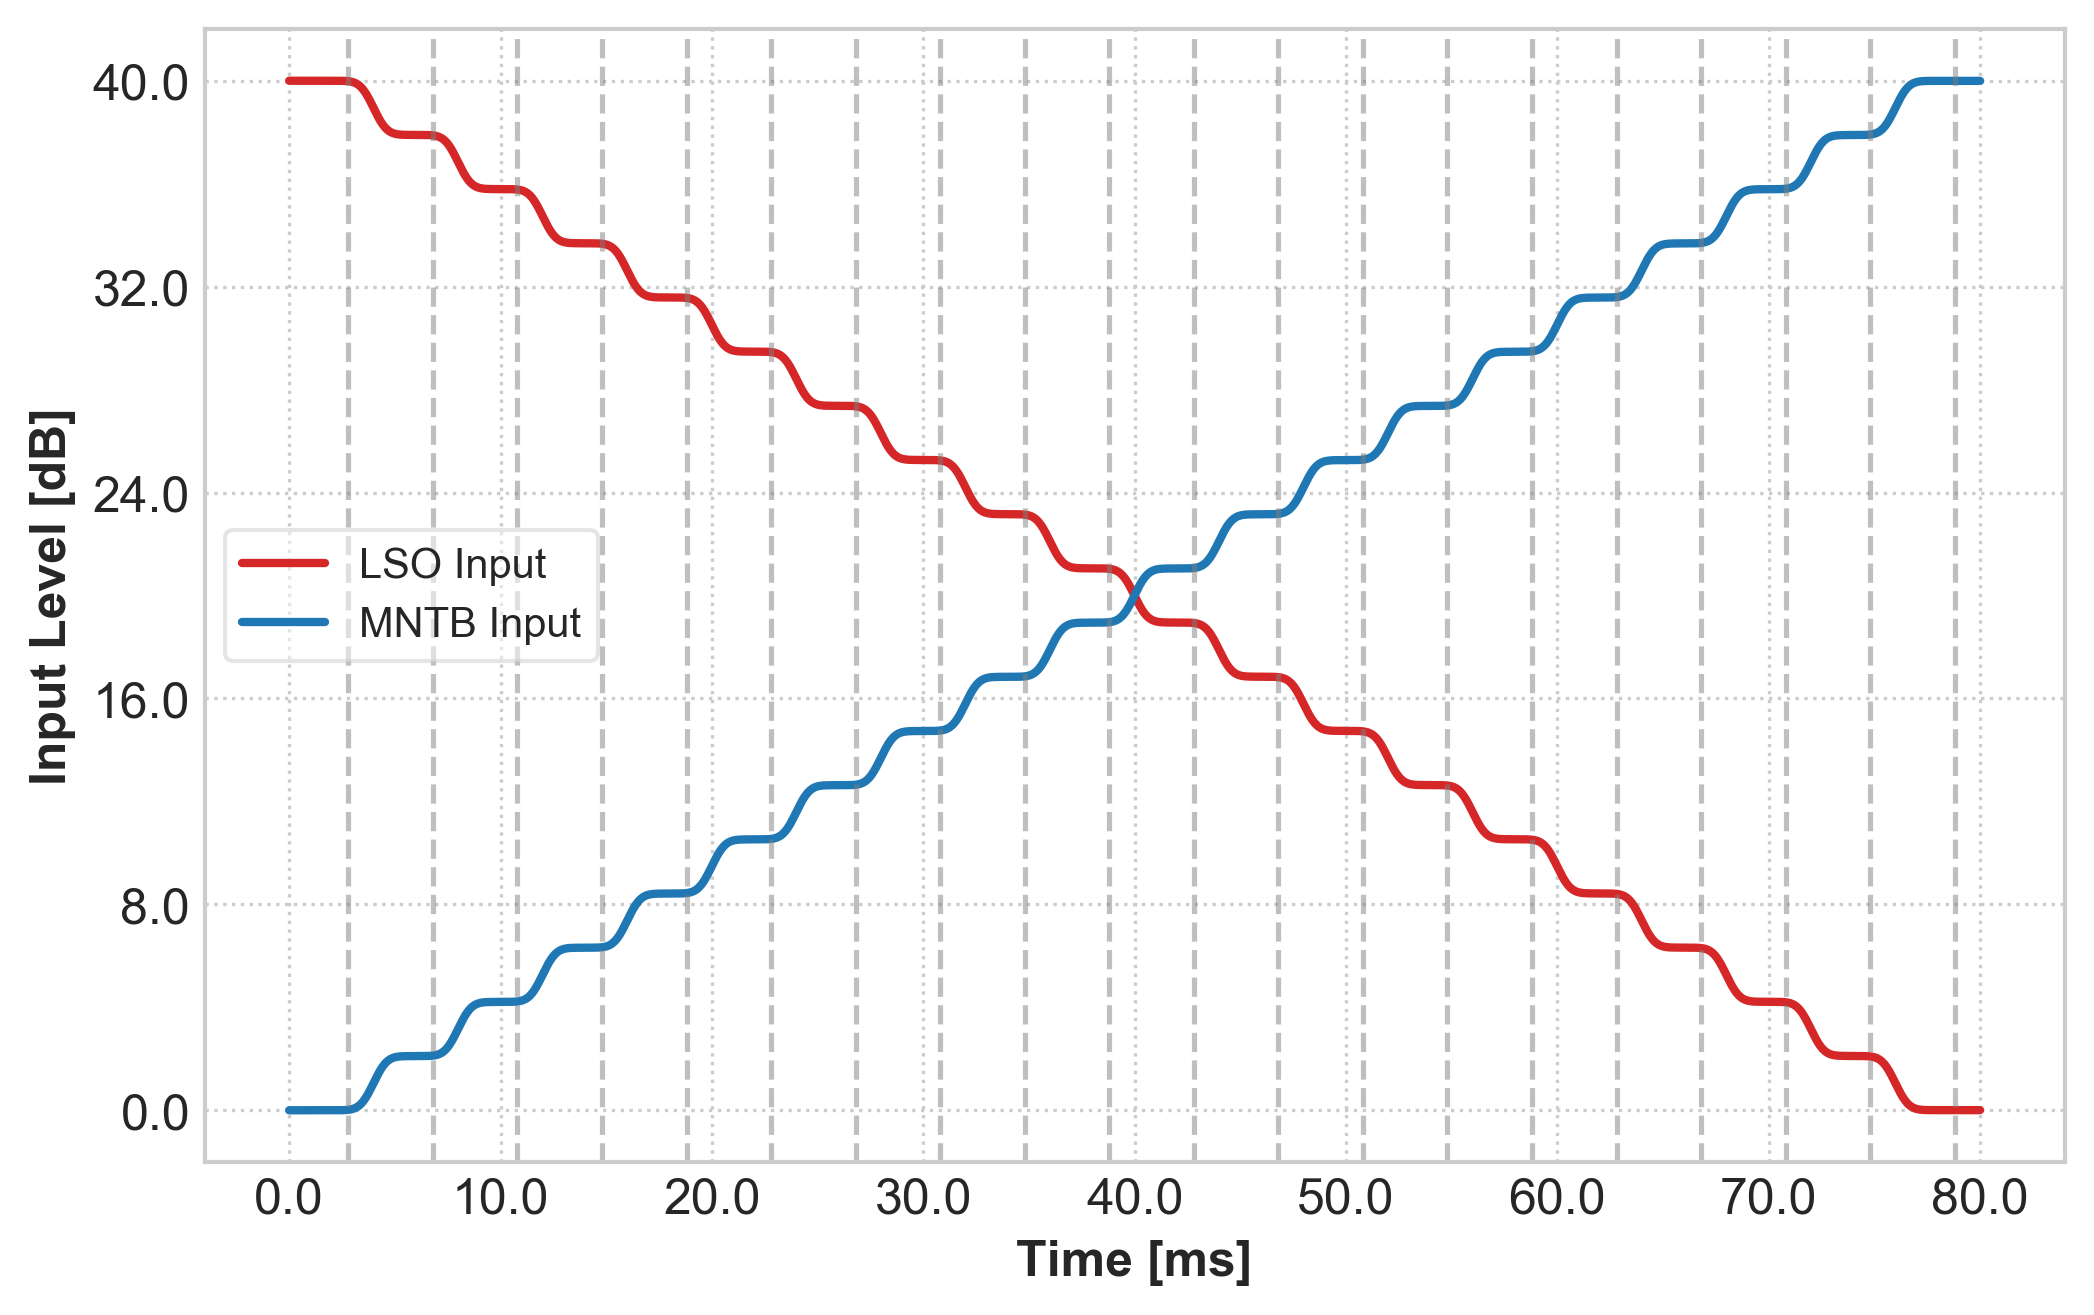

In [273]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(280,len(t),time_window)

fig = plt.figure()
# fig = plt.figure(figsize=(20,10))
# plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2)
ax1.plot(s_sbc_all[:,sbc_center_frequencyBand],'C3',  label='LSO Input')
ax1.plot(s_gbc_all[:,gbc_center_frequencyBand],'C0',  label='MNTB Input')
for i in probing_times:
    ax1.axvline(x=i,linestyle='--',color='grey',alpha = 0.5, linewidth = 1.25)
lgd = plt.legend()

# ax1.set_ylim([0,1])

# l = [0]
# # l.extend(np.linspace(0,40,len(ax1.get_yticklabels())-2))
ax1.set_yticklabels(np.round(ax1.get_yticks()*40))


plt.ylabel('Input Level [dB]')
plt.xlabel('Time [ms]')
ax1.set_xticklabels(ax1.get_xticks()/100)

plt.savefig(figure_name + 'stimuli.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'stimuli.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'stimuli.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()



In [274]:
############################################################
#                       Inputs                             #
############################################################



kappas_r = np.arange(0,16,2)
gamma_r = 1

############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i+2.5*time_window)/(len(t)+4.0*time_window) * gbc_input_strength



# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 0.5

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = sbc_input_strength

    

gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')




# correct for border effect of convolve
s_gbc_all[-250:,:] = np.max(s_gbc_all[-250:])
s_sbc_all[:250,:] = np.max(s_sbc_all[:250])


q_all = np.zeros((len(kappas_r),len(t),freq_bands))
r_all = np.zeros((len(kappas_r),len(t),freq_bands))







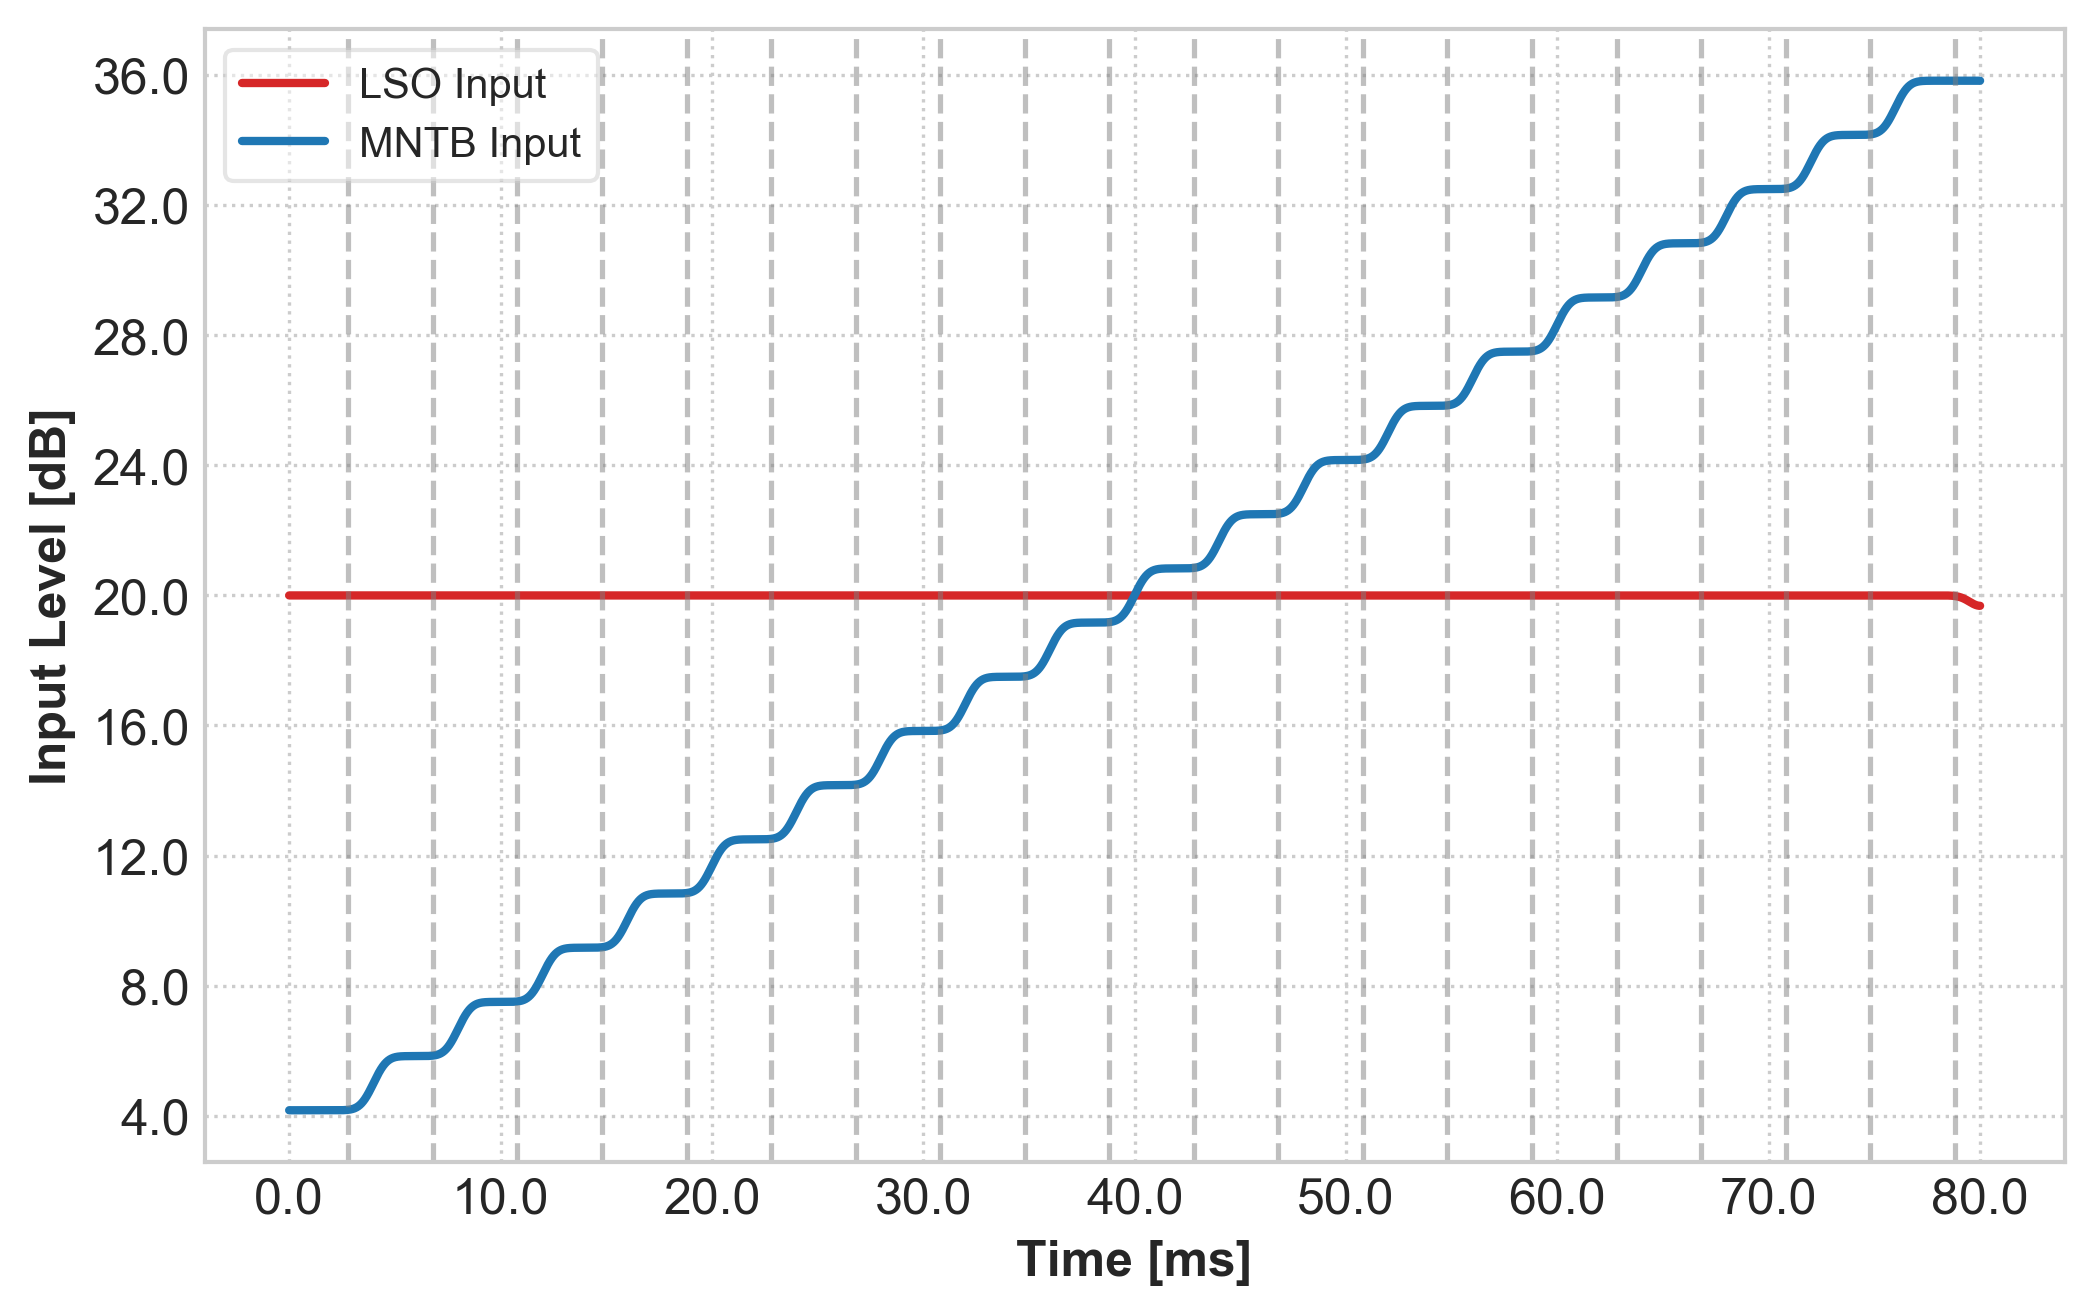

In [275]:
############################################################
#                       Plotting                           #
############################################################
probing_times = np.arange(280,len(t),time_window)

fig = plt.figure()
# fig = plt.figure(figsize=(20,10))
# plt.suptitle('Input to Neuron',fontsize=18)
ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=2)
ax1.plot(s_sbc_all[:,sbc_center_frequencyBand],'C3',  label='LSO Input')
ax1.plot(s_gbc_all[:,gbc_center_frequencyBand],'C0',  label='MNTB Input')
for i in probing_times:
    ax1.axvline(x=i,linestyle='--',color='grey',alpha = 0.5, linewidth = 1.25)
lgd = plt.legend()

# ax1.set_ylim([0,1])

# l = [0]
# # l.extend(np.linspace(0,40,len(ax1.get_yticklabels())-2))
ax1.set_yticklabels(np.round(ax1.get_yticks()*40))


plt.ylabel('Input Level [dB]')
plt.xlabel('Time [ms]')
ax1.set_xticklabels(ax1.get_xticks()/100)

plt.savefig(figure_name + 'stimuli_timing.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'stimuli_timing.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'stimuli_timing.tiff', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

